In [34]:
import numpy as np

from kafka_infra.MongoDbClient import MongoDbClient

client = MongoDbClient("autoencoder_recognized_samples")

In [35]:
domain = np.arange(0.000, 0.020, 0.00025)

In [36]:
def define_pipeline(x):
    pipeline = [
        {
            "$lookup": {
                "from": "generated_samples",
                "localField": "sample_id",
                "foreignField": "sample_id",
                "as": "generated_sample_data"
            }
        },
        {
            "$unwind": "$generated_sample_data"
        },
        {
            "$project": {
                "sample_id": 1,
                "predicted_value": 1,
                "duration": 1,
                "normal_data": "$generated_sample_data.normal_data"
            }
        },
        {
            "$facet": {
                "normal_data_total": [
                    {
                        "$match": {
                            "normal_data": 1
                        }
                    },
                    {
                        "$count": "count"
                    }
                ],
                "normal_data_recognized": [
                    {
                        "$match": {
                            "normal_data": 1,
                            "predicted_value": { "$lte": x }
                        }
                    },
                    {
                        "$count": "count"
                    }
                ],
                "anomalous_data_total": [
                    {
                        "$match": {
                            "normal_data": 0
                        }
                    },
                    {
                        "$count": "count"
                    }
                ],
                "anomalous_data_recognized": [
                    {
                        "$match": {
                            "normal_data": 0,
                            "predicted_value": { "$gt": x }
                        }
                    },
                    {
                        "$count": "count"
                    }
                ]
            }
        },
        {
            "$project": {
                "normal_data_count": { "$arrayElemAt": ["$normal_data_total.count", 0] },
                "correct_recognized_normal_data": { "$arrayElemAt": ["$normal_data_recognized.count", 0] },
                "anomalous_data_count": { "$arrayElemAt": ["$anomalous_data_total.count", 0] },
                "correct_recognized_anomalous_data": { "$arrayElemAt": ["$anomalous_data_recognized.count", 0] }
            }
        }
    ]

    return pipeline

In [73]:
sample_details = []
normal_data_count = -1
anomalous_data_count = -1

In [67]:
pipeline = define_pipeline(domain[50])
result = client.aggregate(pipeline)
for doc in result:
    try:
        doc['correct_recognized_normal_data']
    except KeyError:
        doc['correct_recognized_normal_data'] = 0
    print(doc['correct_recognized_normal_data'])

735


In [45]:
print(sample_details)
print(normal_data_count)
print(anomalous_data_count)

[{'factor': 0.011, 'correct_recognized_normal_data': 633, 'correct_recognized_anomalous_data': 100}]
814
179


In [74]:
for x in domain:
    pipeline = define_pipeline(x)
    result = client.aggregate(pipeline)
    for doc in result:
        if normal_data_count == -1:
            normal_data_count = doc['normal_data_count']
        if anomalous_data_count == -1:
            anomalous_data_count = doc['anomalous_data_count']
        try:
            doc['correct_recognized_normal_data']
        except KeyError:
            doc['correct_recognized_normal_data'] = 0
        try:
            doc['correct_recognized_anomalous_data']
        except KeyError:
            doc['correct_recognized_anomalous_data'] = 0
        sample_details.append({
            'factor': x,
            'correct_recognized_normal_data': doc['correct_recognized_normal_data'],
            'correct_recognized_anomalous_data': doc['correct_recognized_anomalous_data']
        })

In [75]:
print(sample_details)

[{'factor': 0.0, 'correct_recognized_normal_data': 0, 'correct_recognized_anomalous_data': 179}, {'factor': 0.00025, 'correct_recognized_normal_data': 0, 'correct_recognized_anomalous_data': 179}, {'factor': 0.0005, 'correct_recognized_normal_data': 0, 'correct_recognized_anomalous_data': 179}, {'factor': 0.00075, 'correct_recognized_normal_data': 0, 'correct_recognized_anomalous_data': 179}, {'factor': 0.001, 'correct_recognized_normal_data': 0, 'correct_recognized_anomalous_data': 179}, {'factor': 0.00125, 'correct_recognized_normal_data': 0, 'correct_recognized_anomalous_data': 179}, {'factor': 0.0015, 'correct_recognized_normal_data': 0, 'correct_recognized_anomalous_data': 179}, {'factor': 0.00175, 'correct_recognized_normal_data': 0, 'correct_recognized_anomalous_data': 179}, {'factor': 0.002, 'correct_recognized_normal_data': 0, 'correct_recognized_anomalous_data': 179}, {'factor': 0.0022500000000000003, 'correct_recognized_normal_data': 0, 'correct_recognized_anomalous_data': 1

In [81]:
correct_recognized_normal_samples_ratio = []
correct_recognized_anomalous_samples_ratio = []
correct_recognized_samples_ratio = []

for sample in sample_details:
    correct_recognized_normal_samples_ratio.append(sample['correct_recognized_normal_data']/normal_data_count)
    correct_recognized_anomalous_samples_ratio.append(sample['correct_recognized_anomalous_data']/anomalous_data_count)
    correct_recognized_samples_ratio.append((sample['correct_recognized_normal_data'] + sample['correct_recognized_anomalous_data'])/(anomalous_data_count + normal_data_count))

print(correct_recognized_normal_samples_ratio)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0012285012285012285, 0.006142506142506142, 0.009828009828009828, 0.013513513513513514, 0.022113022113022112, 0.02334152334152334, 0.030712530712530713, 0.04176904176904177, 0.05036855036855037, 0.05405405405405406, 0.06633906633906633, 0.0773955773955774, 0.09336609336609336, 0.12039312039312039, 0.14004914004914004, 0.1732186732186732, 0.20515970515970516, 0.23464373464373464, 0.27764127764127766, 0.3132678132678133, 0.3476658476658477, 0.3894348894348894, 0.43366093366093367, 0.4828009828009828, 0.5122850122850123, 0.5614250614250614, 0.5995085995085995, 0.6363636363636364, 0.6842751842751843, 0.7199017199017199, 0.7469287469287469, 0.7776412776412777, 0.8095823095823096, 0.8329238329238329, 0.855036855036855, 0.8759213759213759, 0.8906633906633906, 0.902948402948403, 0.914004914004914, 0.9275184275184275, 0.9434889434889435, 0.9606879606879607, 0.972972972972973, 0.9778869778869779, 0.9815724815724816, 0.98894348894

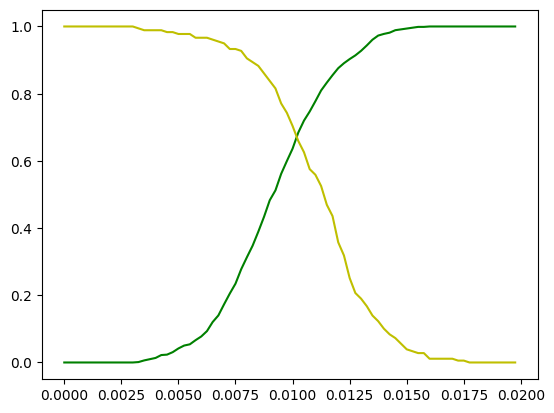

In [79]:
import matplotlib.pyplot as plt

plt.plot(domain, correct_recognized_normal_samples_ratio, 'g')
plt.plot(domain, correct_recognized_anomalous_samples_ratio, 'y')
plt.legend(labels=['Correct recognize'])
plt.show()

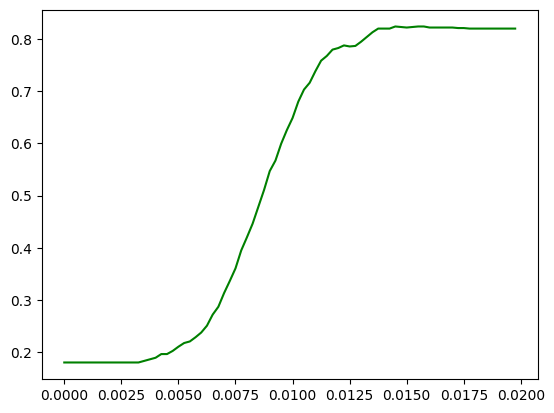

In [82]:
plt.plot(domain, correct_recognized_samples_ratio, 'g')
plt.show()

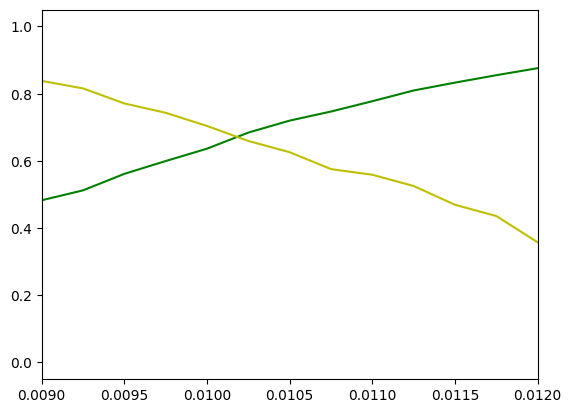

In [80]:

plt.plot(domain, correct_recognized_normal_samples_ratio, 'g')
plt.plot(domain, correct_recognized_anomalous_samples_ratio, 'y')
plt.xlim(0.009, 0.012)
plt.show()

Create function based on value

In [96]:
x = domain
y_1 = correct_recognized_normal_samples_ratio
y_2 = correct_recognized_anomalous_samples_ratio

In [97]:
def get_function(x,y):
    degree = 8
    coefficients = np.polyfit(x, y, degree)
    polynomial_function = np.poly1d(coefficients)

    x_plot = np.linspace(min(x), max(x), 100)

    # Generate y values for plotting the function
    y_plot = polynomial_function(x_plot)

    # Plot the given data points
    plt.scatter(x, y, color='red', label='Given Data')

    # Plot the fitted polynomial function
    plt.plot(x_plot, y_plot, color='blue', label='Fitted Polynomial')

    # Customize the plot
    plt.title('Polynomial Regression')
    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.legend()

    # Show the plot
    plt.show()

    # Print the polynomial function
    print('Fitted Polynomial Function:')
    print(polynomial_function)
    return polynomial_function

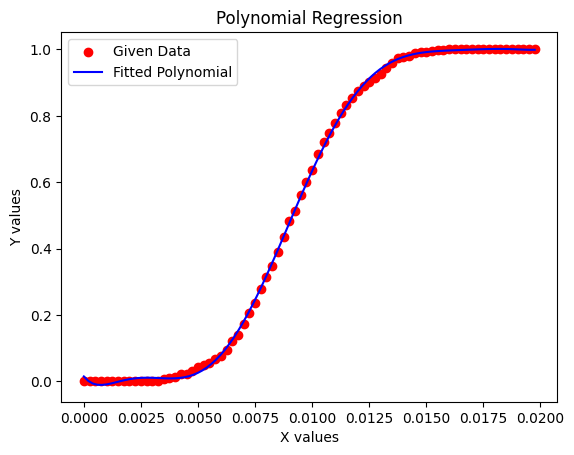

Fitted Polynomial Function:
           8             7             6             5             4
1.533e+16 x - 1.351e+15 x + 4.799e+13 x - 8.712e+11 x + 8.414e+09 x
              3            2
 - 4.116e+07 x + 9.61e+04 x - 86.49 x + 0.01462


In [98]:
func_1 = get_function(x, y_1)

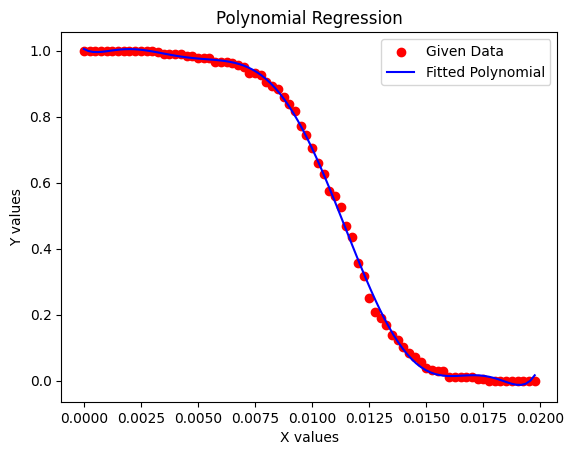

Fitted Polynomial Function:
           8             7             6             5             4
2.938e+16 x - 2.208e+15 x + 6.557e+13 x - 9.748e+11 x + 7.644e+09 x
              3             2
 - 3.124e+07 x + 5.965e+04 x - 42.17 x + 1.005


In [99]:
func_2 = get_function(x, y_2)

In [100]:
temp = func_1 - func_2

In [102]:
correct_recognized_normal_samples_ratio

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0012285012285012285,
 0.006142506142506142,
 0.009828009828009828,
 0.013513513513513514,
 0.022113022113022112,
 0.02334152334152334,
 0.030712530712530713,
 0.04176904176904177,
 0.05036855036855037,
 0.05405405405405406,
 0.06633906633906633,
 0.0773955773955774,
 0.09336609336609336,
 0.12039312039312039,
 0.14004914004914004,
 0.1732186732186732,
 0.20515970515970516,
 0.23464373464373464,
 0.27764127764127766,
 0.3132678132678133,
 0.3476658476658477,
 0.3894348894348894,
 0.43366093366093367,
 0.4828009828009828,
 0.5122850122850123,
 0.5614250614250614,
 0.5995085995085995,
 0.6363636363636364,
 0.6842751842751843,
 0.7199017199017199,
 0.7469287469287469,
 0.7776412776412777,
 0.8095823095823096,
 0.8329238329238329,
 0.855036855036855,
 0.8759213759213759,
 0.8906633906633906,
 0.902948402948403,
 0.914004914004914,
 0.9275184275184275,
 0.9434889434889435,
 0.9606879606879607,
 0.972972972972973

In [106]:
min_difference = float('inf')
for i in range(0, len(correct_recognized_normal_samples_ratio)):
        # Compute the absolute difference between the current pair of values
    difference = abs(correct_recognized_normal_samples_ratio[i] - correct_recognized_anomalous_samples_ratio[i])

        # Check if this pair is closer than the previously found closest pair
    if difference < min_difference:
        # If so, update the closest pair and the minimum difference
        closest_pair = (correct_recognized_normal_samples_ratio[i], correct_recognized_anomalous_samples_ratio[i])
        index = i
        min_difference = difference

print(index)
print(np.mean(closest_pair))

41
0.6717465306850782
